In [3]:
import numpy
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap
import cProfile, pstats

In [2]:
lsst.meas.base.ForcedMeasurementTask.run?

In [2]:
lsst.afw

<module 'lsst.afw' from '/home/kannawad/repo/afw/python/lsst/afw/__init__.py'>

In [4]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detectConfig = lsst.meas.algorithms.SourceDetectionConfig()
detectConfig.returnOriginalFootprints = False
detectConfig.thresholdValue = 10
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

In [5]:
measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.plugins["ext_gaap_GaapFlux"].sigmas = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)

In [5]:
exposure = lsst.afw.image.ExposureF("/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2020_26_GAAP/deepCoadd/HSC-I/9813/8,7.fits") 
table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources

In [6]:
print("# About to start the deblendTask at ", time.ctime())
t1 = time.time()
deblendTask.run(exposure, catalog)
t2 = time.time()
print("# Finished deblendTask in %.2f seconds." % (t2-t1))


# About to start the deblendTask at  Wed May 19 13:26:41 2021
# Finished deblendTask in 16.63 seconds.


In [7]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask.run(catalog, exposure)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))

# Starting the measureTask at  Wed May 19 13:27:11 2021
# Finished measureTask in 288.56 seconds.


In [8]:
times = numpy.loadtxt('timing.txt')
times.sum(), times.mean(), times.std()

OSError: timing.txt not found.

In [ ]:
times.mean()*len(catalog)

In [ ]:
bins = 40
plt.hist(times,bins=bins,histtype='step')
plt.axvline(times.mean(),color='k')
plt.axvspan(times.mean()-times.std(),times.mean()+times.std(),color='grey',alpha=0.4)

In [ ]:
prof = pstats.Stats("nogaap.prof")
prof.sort_stats("cumulative").print_stats(30)

In [8]:
catalog = catalog.copy(deep=True)

In [10]:
numpy.isnan(catalog['ext_gaap_GaapFlux_1_15x_5_0_instFlux']).sum(), len(catalog)

(3008, 3008)

In [ ]:
measureTask.log

In [9]:
catalog.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

In [12]:
good_objects = ~(catalog["ext_gaap_GaapFlux_flag"] | catalog["ext_gaap_GaapFlux_1_15x_Optimal_flag_bigpsf"])

In [216]:
numpy.nanpercentile(yerr, 99)

663.6682857067406

/software/lsstsw/stack_20210415/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6710: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/software/lsstsw/stack_20210415/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6711: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/software/lsstsw/stack_20210415/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-157-fc43135262a5>:11: RuntimeWarning: invalid value encountered in true_divide
  snr = catalog[baseName+"_instFlux"][good_objects]/catalog[baseName+"_instFluxErr"][good_objects]


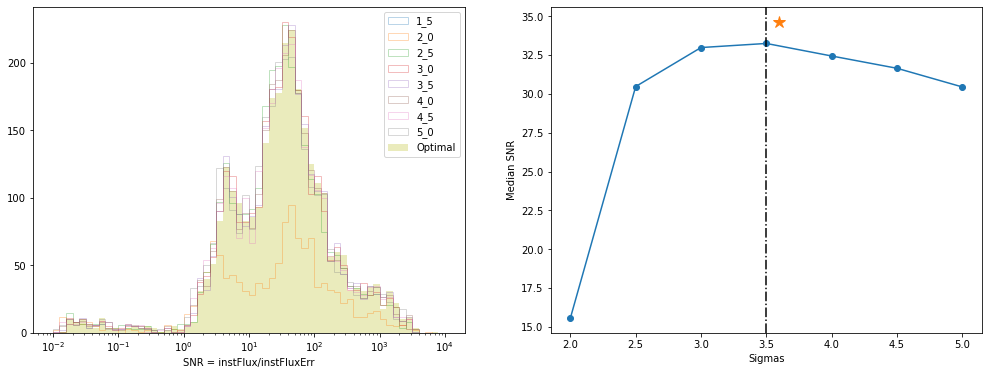

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = numpy.logspace(-2,4,61)
baseNames = list(measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"))
statistic_list = []
statistic_upper_list, statistic_lower_list = [], []
for baseName in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
    label = baseName.split("x_")[-1]
    #if label[-1]=='5': continue
    if "PsfFlux" in label: continue
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = catalog[baseName+"_instFlux"][good_objects]/catalog[baseName+"_instFluxErr"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype,label=label, alpha=0.3)
    statistic = numpy.nanpercentile(snr, 50)
    # statistic = numpy.nanmean(snr)
    if "Optimal" in label:
        optStatistic = numpy.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(numpy.percentile(snr, 84))
        statistic_lower_list.append(numpy.percentile(snr, 16))

ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = measureConfig.plugins["ext_gaap_GaapFlux"].sigmas.list()
ax[1].plot(sigmas, statistic_list, 'o-')
#ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")
ax[1].axvline(3.5, color='k', ls='-.')

In [132]:
X, Y = [], []
for record in catalog[good_objects]:
    snr_list = []
    optShape = afwGeom.Quadrupole(catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                                  catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                                  catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
    optSigma = optShape.getDeterminantRadius()
    optSigma = numpy.round(optSigma*2,0)/2
    optName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(1.15, optSigma, "ext_gaap_GaapFlux")
    for baseName in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
        if not ("PsfFlux" in baseName or "Optimal" in baseName):
            try:
                snr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]
                snr_list.append(snr)
            except ZeroDivisionError:
                continue
        elif "Optimal" in baseName:
            optimalSnr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]
            
        if baseName==optName:
            optSnr = snr
        if 'x_3_5' in baseName:
            optSnr = snr
            
    boostFactor = optimalSnr/optSnr # numpy.nanpercentile(snr_list, 50)
    shape = record.getShape()
    ellip = (shape.getIxx()-shape.getIyy()) + 1j*2*shape.getIxy()
    ellip /= (shape.getIxx()+shape.getIyy())
    
    X.append( numpy.hypot(ellip.real, ellip.imag))
    Y.append(boostFactor)
    
Y = numpy.array(Y)

Text(0.5, 1.0, 'Plot covers 97.92 % of the sources.')

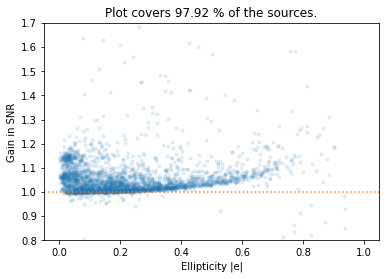

In [133]:
plt.plot(X, Y, '.', alpha=0.1)
plt.axhline(1.0, color='C1',ls=':')
#plt.yscale('log')
plt.ylabel("Gain in SNR")
plt.xlabel("Ellipticity |e|")
ymin, ymax = 0.8, 2.7
plt.ylim([0.8,1.7])
plt.title(f"Plot covers {100.*((Y>ymin)&(Y<ymax)).mean():.2f} % of the sources.")

In [103]:
(numpy.array(Y)<5).sum()/len(Y)

0.9948962232051718

In [92]:
def printShape(shape):
    ixx, iyy, ixy = shape.getParameterVector()
    det = shape.getDeterminantRadius()
    complex_ellip = ((ixx-iyy)+1j*2*ixy)/(ixx+iyy)
    ellip = numpy.hypot(complex_ellip.real, complex_ellip.imag)
    # return f"Quad(ixx={ixx:.2f}, iyy={iyy:.2f}, ixy={ixy:.2f}); det={det:.1f}; |e|={ellip:.2f}"
    return rf"$\sigma = ${det:.1f}; |e|={ellip:.2f}"

printShape(shape)

'$\\sigma = $2.3; |e|=0.22'

Text(0.5, 1.0, 'recordId = 100')

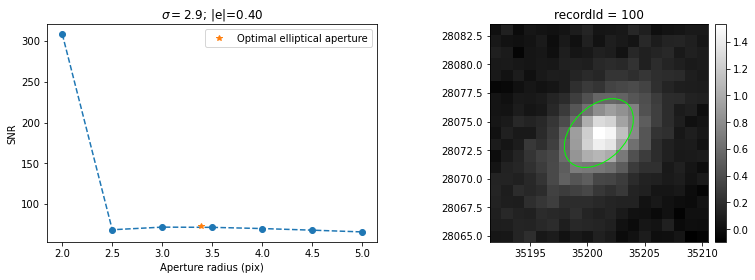

In [161]:
recordId = 100
scalingFactor = 1.15

def getSnr(sigmas):
    for sigma in sigmas:
        baseName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(scalingFactor, sigma, "ext_gaap_GaapFlux")
        snr = catalog[recordId][baseName+"_instFlux"]/catalog[recordId][baseName+"_instFluxErr"]
        yield snr
        
sigmas = numpy.array(measureConfig.plugins["ext_gaap_GaapFlux"].sigmas)
snrs = numpy.array(list(getSnr(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].plot(sigmas[snrs>0], snrs[snrs>0], 'o--')

shape = catalog[recordId].getShape()
optShape = afwGeom.Quadrupole(catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
sigma = optShape.getDeterminantRadius()
snr = list(getSnr(("Optimal",)))[0]
ax[0].plot(sigma, snr, '*', label='Optimal elliptical aperture')

ax[0].set_ylabel("SNR")
ax[0].set_xlabel("Aperture radius (pix)")
ax[0].set_title(printShape(shape))
#plt.yscale('log')
ax[0].legend(loc='best')


afwDisplay.setDefaultBackend('matplotlib')
plt.sca(ax[1])
display = afwDisplay.Display(frame=fig)
# display.scale("linear", "zscale")
display.setMaskTransparency(100)
footprint = catalog[recordId].getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *bbox.getCenter())
ax[1].set_title(f"recordId = {recordId}")

In [186]:
display.mtv?

In [50]:
numpy.isnan(snr_4).sum(), (~good_objects).sum(), (catalog["ext_gaap_GaapFlux_1_15x_4_0_flag_bigpsf"]).sum()

(50, 50, 0)

In [45]:
numpy.nanmedian(snr_optimal), numpy.nanmedian(snr_4), numpy.nanmedian(snr_5)

(34.964681096945895, 32.1867287113446, 30.280777014777087)

In [84]:
[ nam.split('x_')[-1] for nam in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux") ]

['1_5', '2_0', '2_5', '3_0', '3_5', '4_0', '4_5', '5_0', 'PsfFlux', 'Optimal']

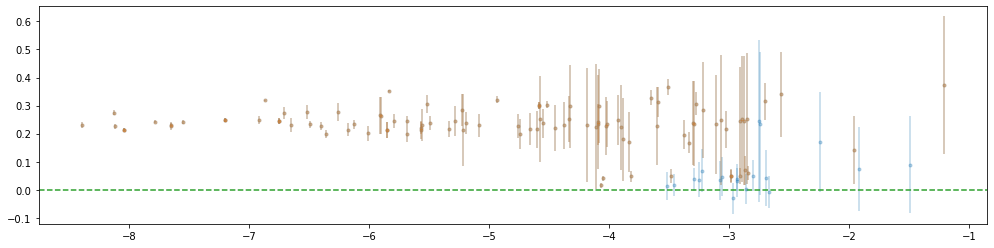

In [145]:
traceRadius = catalog.getIxx()+catalog.getIyy()
stars = traceRadius < numpy.nanpercentile(traceRadius,5)
fig, ax = plt.subplots(figsize=(17,4))
x = -2.5*numpy.log10(catalog["base_PsfFlux_instFlux"])
# x = catalog["base_PsfFlux_instFlux"]
y = -2.5*numpy.log10(catalog["ext_gaap_GaapFlux_1_15x_PsfFlux_instFlux"]/catalog["base_PsfFlux_instFlux"]) #-1
yerr = (2.5/numpy.log(10))*catalog["ext_gaap_GaapFlux_1_15x_PsfFlux_instFluxErr"]/catalog["ext_gaap_GaapFlux_1_15x_PsfFlux_instFlux"]
cuts = (yerr <= numpy.nanpercentile(yerr, 90)) & stars
ax.errorbar(x[cuts], y[cuts], yerr[cuts], marker='.',ls=' ',alpha=0.3)
cuts = cuts & (y-yerr>0)
ax.errorbar(x[cuts], y[cuts], yerr[cuts], marker='.',ls=' ',alpha=0.3)
ax.axhline(0.0, color="C2", ls='--')
#plt.xscale('log'); plt.yscale('log')
#plt.xlim([0,10]); plt.ylim([0,10])

In [28]:
afwGeom.Quadrupole.g

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['Flag'](name="deblend_deblendedAsPsf", doc="Deblender thought this source looked like a PSF"), Key['Flag'](offset=40, bit=0)),
    (Field['D'](name="deblend_psfCenter_x", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['D'](name="deblend_psfCenter_y", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=56, nElements=1)),
    (Field['D'](name="deblend_psf_instFlux", doc="If deblended-as-psf

In [135]:
catalog.getIxx()

array([115.21680097,   4.66975897,   8.00795564, ...,  34.9591689 ,
        13.82477653,  15.18697566])